In [ ]:
# Setup to copy github repo to Google drive and import from colab.
# Based on https://zerowithdot.com/colab-github-workflow/

from google.colab import drive
import os

ROOT = '/content/drive'     # Default for the drive.
PROJ = 'My Drive/dsa_repo'  # Path to project on drive.

GIT_USERNAME = "PraChetit"  # Replace with yours.
GIT_REPOSITORY = "dsa_repo"

drive.mount(ROOT)           # Mount the drive at /content/drive.

PROJECT_PATH = os.path.join(ROOT, PROJ)
# !mkdir "{PROJECT_PATH}"     # In case it is not created it already.

!git clone https://github.com/PraChetit/dsa_repo.git
!mv ./dsa_repo/* "{PROJECT_PATH}"
!rm -rf ./dsa_repo
!rsync -aP --exclude=data/ "{PROJECT_PATH}"/*  ./

# Comparing sorting algorithms

In computer science, a sorting algorithm is an algorithm that puts elements of a list in a certain order. 

This notebook experimentally compares sorting arrays implemented in this reporitory, and illustrates some good practices in organizing and plotting such experimental data.

In [143]:
import dataclasses
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import time

from algorithms.sorting.bubble import bubble_sort
from algorithms.sorting.comb import comb_sort
from algorithms.sorting.gnome import gnome_sort
from algorithms.sorting.heap import heap_sort
from algorithms.sorting.insertion import insertion_sort
from algorithms.sorting.merge import merge_sort
from algorithms.sorting.quick import quick_sort
from algorithms.sorting.shell import shell_sort
from algorithms.sorting.tree import tree_sort

### Preparation

We compare two broad classes of slow and fast algorithms: "slow" and "fast".

The computational complexity of slow algorithms is $ O(n^2) $, while the complexity of fast algorithms is $ O(n \log(n)) $... with the exception of Shell sort, which is a bit [more complicated](https://en.wikipedia.org/wiki/Shellsort#Computational_complexity) but asymptotically slower, yet preferred in certain applications.

In [144]:
REPETITIONS=10  # Number of independent repetitions of each trial.

# Slow sorts.
BUBBLE = ('bubble', bubble_sort)
COMB = ('comb', comb_sort)
GNOME = ('gnome', gnome_sort)
INSERT = ('insertion', insertion_sort)
SLOW = [BUBBLE, COMB, GNOME, INSERT]

# Fast sorts.
HEAP = ('heap', heap_sort)
MERGE = ('merge', merge_sort)
QUICK = ('quick', quick_sort)
SHELL = ('shell', shell_sort)
TREE = ('tree', tree_sort)
FAST = [MERGE, QUICK, SHELL, HEAP, TREE]

In [145]:
@dataclasses.dataclass(frozen=True)
class Setup:
  """Container for experiment setup."""
  size: int
  algs: list

setup_1 = Setup(100, SLOW + FAST)
setup_2 = Setup(300, SLOW + FAST)
setup_3 = Setup(1000, SLOW + FAST)
setup_4 = Setup(3000, SLOW + FAST)
setup_5 = Setup(10000, SLOW + FAST)
# Not running slow algorithms on larger inputs.
setup_6 = Setup(30000, FAST)
setup_7 = Setup(100000, FAST)
setup_8 = Setup(300000, FAST)
setups = [setup_1, setup_2, setup_3, setup_4, setup_5, setup_6, setup_7, setup_8]

# setup_0 = Setup(100, [STOOGE])

### Running experiments

We use pandas `DataFrame` to organize the results from experiments. This is useful for data exploration afterwards, and for compatibility with other libraries for visualizing data.

We will create a randomly reshuffled array as the experimental input. Note that other inputs would also be interesting to look at, for instance partially shuffled, reverse ordered, etc. For simlicity, we focus only on this one scenario.

The interesting part is comparing the algorithms relative to each other, not necessarily the value of an absolute metric, such as time.

In [146]:
# Some utilities for running experiments.

def create_test_array(size: int, seed: int):
  """Given `seed`, returns a randomly ordered array of `size` elements."""
  array = list(range(size))
  random.seed(seed)
  random.shuffle(array)
  return array
  
def run(sorting_alg: Callable, size: int, seed: int):
  """Sorts an array and returns time required to do so."""
  array = create_test_array(size, seed)
  start_t = time.time()
  sorting_alg(array)
  end_t = time.time()
  return end_t - start_t
  
def experiment(df: pd.DataFrame, setup: Setup, repetitions: int):
  """Runs an experiment for a number of algorithms."""
  for round in range(repetitions):
    random.seed()  # Resets seeding.
    seed = random.randrange(2**32)

    for name, sorting_alg in setup.algs:
      t = run(sorting_alg, setup.size, seed)
      df = df.append({'Algorithm': name,
                      'Round': round,
                      'Array_size': setup.size,
                      'Time': t},
                     ignore_index=True)
  return df

In [147]:
# Run the experiment.

df = pd.DataFrame()

for setup in setups:
  df = experiment(df, setup, REPETITIONS)

# Analysis

Create some helper methods for slicing parts of the `DataFrame` we created.

In [163]:
def filter_slow_algs(df):
  return df[df['Algorithm'].isin(list(zip(*SLOW))[0])]

def filter_fast_algs(df):
  return df[df['Algorithm'].isin(list(zip(*FAST))[0])]

#### Slow algorithms

Below, we plot the array size vs. the time it takes to sort the array in several ways.

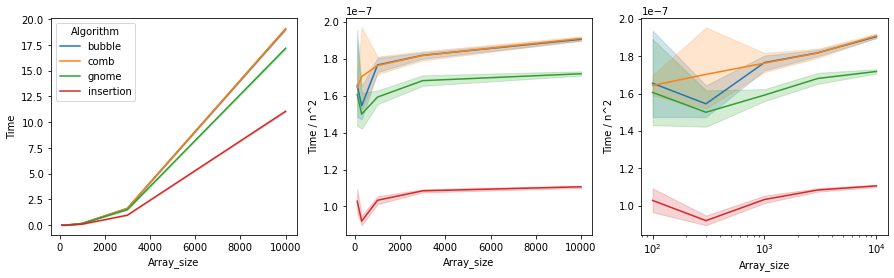

In [172]:
plt.rcParams["figure.figsize"] = (15,4)

# Create the new column in DataFrame.
df['Time_by_n2'] = df.apply(lambda r: r.Time / (r.Array_size * r.Array_size),
                            axis=1)

plt.subplots(1, 3)
plt.subplot(1, 3, 1)
sns.lineplot(data=filter_slow_algs(df),
             x='Array_size', y='Time', hue='Algorithm')

plt.subplot(1, 3, 2)
sns.lineplot(data=filter_slow_algs(df),
             x='Array_size', y='Time_by_n2', hue='Algorithm', legend=False)
plt.ylabel('Time / n^2')

plt.subplot(1, 3, 3)
sns.lineplot(data=filter_slow_algs(df),
             x='Array_size', y='Time_by_n2', hue='Algorithm', legend=False)
plt.xscale('log')
plt.ylabel('Time / n^2')

plt.show()

Plotting directly against time (left plot) is not as insightful as normalizing the y-axis by $n^2$ (middle and right plot) -- recall that the slow algorithms have the computational complexity of $O(n^2)$. Note also, given how we chose the experiment sizes, it is better to use log-scale on the x-axis (right plot), to not have the data squeezed in the left-hand side of the plot.

Given the repetitions of each experiment in the data frame ('Round' column), the `seaborn` library will by default include a visualization of the variance of the values across the repetitions.

In the latter two plots, the relationship seems to be nearly constant for all algorithms, which is as expected given the theoretical upper bounds.

Insertion sort seems to be the fastest, with little variance overall.

The other three algorithms have similar speed, with higher variance for small inputs, but the variance decreases as inputs get larger.

#### Fast algorithms

A similar comparison for fast algorithms, but we normalize by $n\log(n)$.

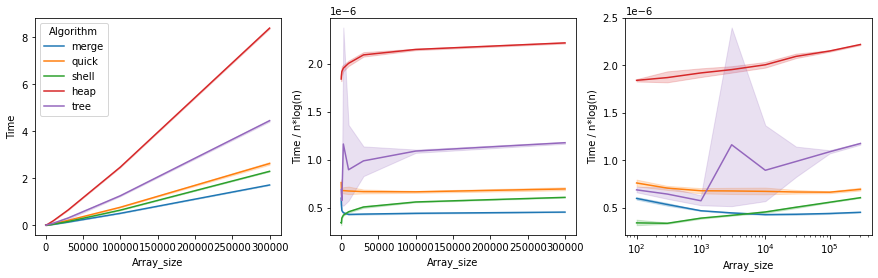

In [173]:
plt.rcParams["figure.figsize"] = (15,4)

# Create the new column in DataFrame.
df['Time_by_nlogn'] = df.apply(
    lambda r: r.Time / (r.Array_size * math.log(r.Array_size)),
    axis=1)

plt.subplots(1, 3)
plt.subplot(1, 3, 1)
sns.lineplot(data=filter_fast_algs(df),
             x='Array_size', y='Time', hue='Algorithm')

plt.subplot(1, 3, 2)
sns.lineplot(data=filter_fast_algs(df),
             x='Array_size', y='Time_by_nlogn', hue='Algorithm', legend=False)
plt.ylabel('Time / n*log(n)')

plt.subplot(1, 3, 3)
sns.lineplot(data=filter_fast_algs(df),
             x='Array_size', y='Time_by_nlogn', hue='Algorithm', legend=False)
plt.xscale('log')
plt.ylabel('Time / n*log(n)')

plt.show()

Heapsort seems to be overall the slowest. The heap data structure is more generlly useful, and if used directly for sorting (as done here), it requires more comparisions than other fast sorts typically need. A variant of this sort, [bottom-up heapsort](https://en.wikipedia.org/wiki/Heapsort#Bottom-up_heapsort) would likely be faster.

Treesort is doing something strange. Since this is done based on a naive implementation of the binary search tree, there is a chance to be "unlucky" and the input array results in a very unbalanced tree in the process. This would likely be improved by a better implementation of the tree. An interesting regime seems to be around array size of `3000` which seems to result in a high variance in time. Not sure why, but I wonder if something could be said about this in theory.

The other three algorithms seem to perform similarly. Let's look at them closer.

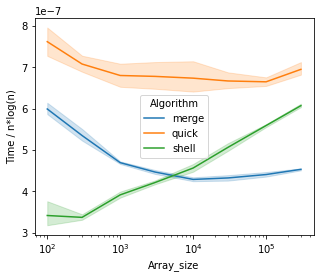

In [175]:
plt.rcParams["figure.figsize"] = (5,4)
sns.lineplot(data=df[df['Algorithm'].isin(list(zip(*[MERGE, QUICK, SHELL]))[0])],
             x='Array_size', y='Time_by_nlogn', hue='Algorithm')
plt.ylabel('Time / n*log(n)')
plt.xscale('log')

Shell sort seems to be consistently increasing with array size. This is as expected, as its asymptotic complexity is not $O(n\log(n))$. However, it can clearly be very effective in the non-asymptotic regimes.

The two other sorts, merge and quick, seem to have some constant overhead for small array sizes, which result in the lines with negative slope initially, but appear roughly constant for larger array sizes.

The implemented quick sort is its basic variant. There are numerous ways to make quick sort more effective, especially when selecting the pivot, and I expect the performance could be improved further.

#### Log-log plot

Assume we do not know about the expected relationship between array size and the time to sort the array ($O(n^2)$ and $O(n\log(n))$). Instead, we want to read it from the experimental data.

We can do this using log-log plots, where relationships of the form $y = ax^b$ will be linear with slope $b$. 

From the plot below, it is immediately clear that the algorithms fall into two distinct groups with qualitatively different relationship between the array size and the time it takes to sort them.

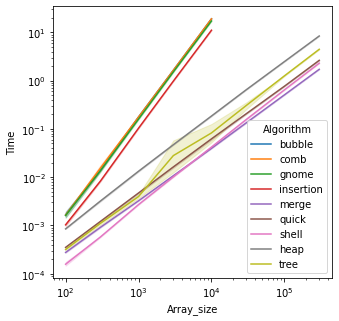

In [169]:
plt.rcParams["figure.figsize"] = (5,5)

sns.lineplot(data=df, x='Array_size', y='Time', hue='Algorithm')
plt.yscale('log')
plt.xscale('log')

The complexity of the slow algorithms should be $O(n^2)$, which would be reflected in the log-log plot by a line with slope $2$. This seems to be roughly the case for the slow algorithms.